In [8]:
# ─── 0) Install & import ──────────────────────────────────────────────────────
# !pip install keras-tuner  # uncomment if you haven’t installed it yet

import numpy as np
import matplotlib.pyplot as plt

import kerastuner as kt
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler, label_binarize
from sklearn.metrics         import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
from sklearn.decomposition   import PCA

# reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [9]:
# ─── 1) Load & split your data (metadata only) ────────────────────────────────
data     = np.load('threebody_dataset2.npz')
y        = data['y'][:-1]      # shape (301,)
labels   = data['labels']    # e.g. ['C','D','S']
masses   = data['masses'][:-1]    # (301, 3)
init_pos = data['init_pos'][:-1]  # (301, 3, 2)
init_vel = data['init_vel'][:-1]  # (301, 3, 2)

# flatten metadata to (301, 15)
meta = np.hstack([
    masses,
    init_pos.reshape(len(y), -1),
    init_vel.reshape(len(y), -1)
])

# stratified train + validation/test split (85/15)
meta_train, meta_test, y_train, y_test = train_test_split(
    meta, y,
    test_size=0.15,
    stratify=y,
    random_state=seed
)

# compute validation split fraction relative to meta_train
val_split = 0.15 / 0.85    # ≈0.1765 → yields 15% of original as validation

# scale metadata features
scaler     = StandardScaler()
meta_train = scaler.fit_transform(meta_train)
meta_test  = scaler.transform(meta_test)

n_meta, n_classes = meta.shape[1], len(labels)

In [10]:
# ─── 2) Define model-building fn for Keras-Tuner (metadata-only) ─────────────
def build_meta_model(hp):
    # Hyperparameters to search
    dense1_units = hp.Choice('dense1_units', [32, 64, 128])
    dense2_units = hp.Choice('dense2_units', [16, 32, 64])
    drop_rate    = hp.Float ('dropout',       0.0, 0.5, step=0.1)
    lr           = hp.Float ('learning_rate', 1e-4, 1e-2, sampling='log')

    # metadata input branch
    meta_in = Input(shape=(n_meta,), name='meta_input')
    x = Dropout(drop_rate, name='drop1')(meta_in)
    x = Dense(dense1_units, activation='relu', name='dense1')(x)
    x = Dropout(drop_rate, name='drop2')(x)
    x = Dense(dense2_units, activation='relu', name='dense2')(x)
    out = Dense(n_classes, activation='softmax', name='classifier')(x)

    model = Model(meta_in, out)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [11]:
# ─── 3) Set up & run the tuner ─────────────────────────────────────────────────
tuner = kt.RandomSearch(
    build_meta_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='meta_tuner',
    project_name='threebody_meta',
    overwrite=True
)

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(
    meta_train,
    y_train,
    validation_split=val_split,
    epochs=30,
    batch_size=16,
    callbacks=[es],
    verbose=2
)

# Retrieve the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hp.values)

# ─── 4) Build & retrain best model on full training+validation data ─────────
best_meta_model = tuner.hypermodel.build(best_hp)
history = best_meta_model.fit(
    meta_train,
    y_train,
    validation_split=val_split,
    epochs=50,
    batch_size=16,
    callbacks=[es],
    verbose=2
)

Trial 15 Complete [00h 00m 01s]
val_accuracy: 0.9555555582046509

Best val_accuracy So Far: 0.9555555582046509
Total elapsed time: 00h 00m 14s
Best hyperparameters: {'dense1_units': 128, 'dense2_units': 16, 'dropout': 0.0, 'learning_rate': 0.003494010606074571}


Epoch 1/50
14/14 - 0s - loss: 0.7686 - accuracy: 0.7095 - val_loss: 0.5060 - val_accuracy: 0.8000 - 233ms/epoch - 17ms/step
Epoch 2/50
14/14 - 0s - loss: 0.3535 - accuracy: 0.8714 - val_loss: 0.3055 - val_accuracy: 0.8667 - 18ms/epoch - 1ms/step
Epoch 3/50
14/14 - 0s - loss: 0.2181 - accuracy: 0.9238 - val_loss: 0.2236 - val_accuracy: 0.8889 - 17ms/epoch - 1ms/step
Epoch 4/50
14/14 - 0s - loss: 0.1748 - accuracy: 0.9429 - val_loss: 0.2000 - val_accuracy: 0.8889 - 17ms/epoch - 1ms/step
Epoch 5/50
14/14 - 0s - loss: 0.1619 - accuracy: 0.9381 - val_loss: 0.1904 - val_accuracy: 0.9556 - 16ms/epoch - 1ms/step
Epoch 6/50
14/14 - 0s - loss: 0.1495 - accuracy: 0.9476 - val_loss: 0.1944 - val_accuracy: 0.9556 - 16ms/epoch - 1ms/step
Epoch 7/50
14/14 - 0s - loss: 0.1394 - accuracy: 0.9476 - val_loss: 0.1650 - val_accuracy: 0.9556 - 15ms/epoch - 1ms/step
Epoch 8/50
14/14 - 0s - loss: 0.1453 - accuracy: 0.9429 - val_loss: 0.1791 - val_accuracy: 0.9333 - 15ms/epoch - 1ms/step
Epoch 9/50
14/14 - 0s 

In [12]:
# ─── 5) Evaluate on the test set ───────────────────────────────────────────────
test_loss, test_acc = best_meta_model.evaluate(meta_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.2%}\n")

y_pred_probs = best_meta_model.predict(meta_test)
y_pred       = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred, target_names=labels))


Test Accuracy: 97.78%

2/2 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           C       1.00      0.93      0.97        15
           D       0.94      1.00      0.97        15
           S       1.00      1.00      1.00        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



In [13]:
# ─── 5) Evaluate on the test set ───────────────────────────────────────────────
test_loss, test_acc = best_meta_model.evaluate(meta_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.2%}\n")

y_pred_probs = best_meta_model.predict(meta_test)
y_pred       = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred, target_names=labels))


Test Accuracy: 97.78%

2/2 [==============================] - 0s 932us/step
              precision    recall  f1-score   support

           C       1.00      0.93      0.97        15
           D       0.94      1.00      0.97        15
           S       1.00      1.00      1.00        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



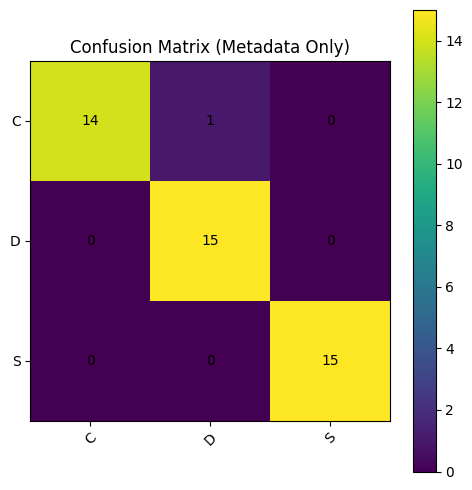

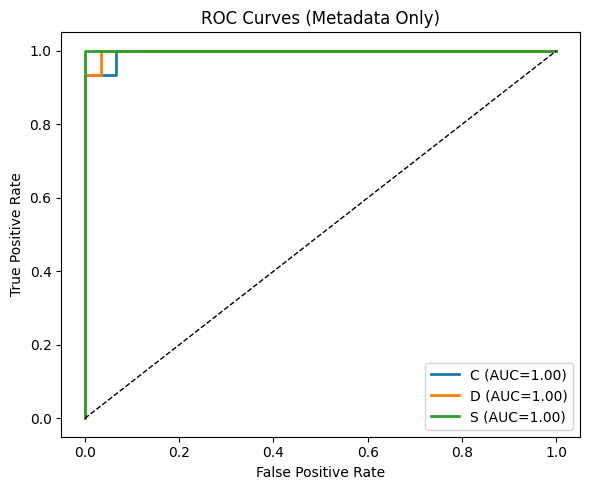

2/2 [==============================] - 0s 1ms/step


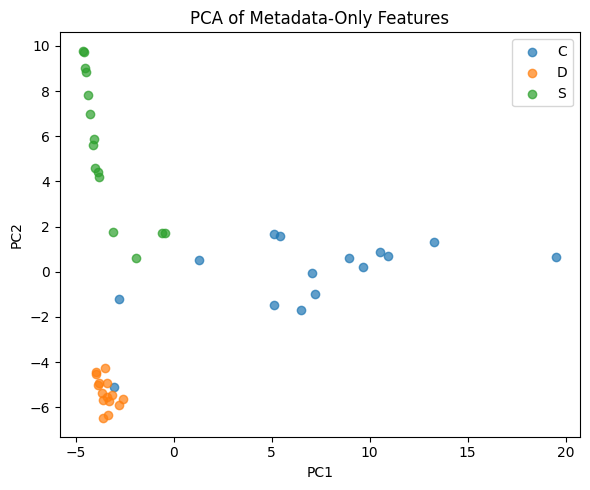

In [14]:
# ─── 6) Analysis plots ─────────────────────────────────────────────────────────
# 6a) Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.title("Confusion Matrix (Metadata Only)")
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
plt.xticks(range(n_classes), labels, rotation=45)
plt.yticks(range(n_classes), labels)
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()

# 6b) ROC curves (one-vs-rest)
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
plt.figure(figsize=(6,5))
for i, lab in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{lab} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Metadata Only)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 6c) PCA scatter of learned features (dense2 layer)
from tensorflow.keras.models import Model
feat_extractor = Model(
    inputs=best_meta_model.input,
    outputs=best_meta_model.get_layer('dense2').output
)
features = feat_extractor.predict(meta_test)
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=seed)
pcs = pca.fit_transform(features)
plt.figure(figsize=(6,5))
for idx, lab in enumerate(labels):
    mask = (y_test == idx)
    plt.scatter(pcs[mask,0], pcs[mask,1], alpha=0.7, label=lab)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Metadata-Only Features")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd

# Collect ROC data
roc_data = []
for i, lab in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc     = auc(fpr, tpr)
    for f, t in zip(fpr, tpr):
        roc_data.append({
            "model": "GRU",  # Change to "GRU" or "LSTM" in respective scripts
            "class": lab,
            "fpr": f,
            "tpr": t,
            "auc": roc_auc
        })

# Save to CSV
df_roc = pd.DataFrame(roc_data)
df_roc.to_csv("roc_data_gru.csv", index=False)  # Use different file names per model